## Import modules and functions
Unlike Matlab which has in-built functions, in Python people/groups make packages where they write functions for different purposes (e.g. image processing, statistics, plotting etc.). Here we import different packages are functions that have been made for the analyses that we need to run.
Some of these are not used, but I was lazy to sift through it.

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

## Specify the directory to read the files from
This is the folder where all of your integrin imaging folders are

In [3]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

## Read the correlations calculated in Matlab
In Matlab, each of your clicks drew a line in the organelle channel and at the same location in the integrin channel. The correlation between the intensity values in both channels was calculated (look up 'Pearson's correlation coefficient). In each folder, a file is created called 'normal_corrs_all.txt' which contains a list where each value is the average correlation coefficient for one image in the folder.

Running the code below will make something called a 'dictionary' for storing the results (imagine it like an excel worksheet with column headings, and values filling these columns). We will call this dictionary 'results' and the column heading: 
- 'filename' (for storing the filename of the normal-corrs-all.txt filename
- 'exp condition' (for storing the name of the containing folder, which is essentially, the name of the protein we're looking at)

In [ ]:
results = {"filename":[],
          "exp condition":[],
          "mean correlation":[],
          "correlation":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "normal_corrs_all" in str(filelist[i]):
            if filelist[i].endswith(".txt"): 
                if str(filelist[i][:-12]) not in str(results["filename"]):
                    results["filename"].append(filelist[i])
                    results["exp condition"].append(filelist[i].split('/')[-2])
                    results["correlation"].append(np.loadtxt(filelist[i]))

## Make a dataframe of the results
We will convert the 'dictionary' that we made above with the results into another Python file format called a 'dataframe'. This is really like an excel sheet, and the main advantage is that there is an entire Python package called 'Pandas' (cute, right? :) ) which was written specifically for data analysis and which lets you do all kinds of analyses very easily and automatically with this file type.

We'll also make a new column called 'Protein' to the dataframe to make things nicer and more readable

In [ ]:
newdf=pd.DataFrame(results)

newdf['Protein']='None'

newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
newdf.loc[newdf['filename'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab11'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
newdf.loc[newdf['filename'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
newdf.loc[newdf['filename'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'
newdf.loc[newdf['filename'].str.contains('rab7'), 'Protein'] = 'Rab7/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab5'), 'Protein'] = 'Rab5/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('lamp'), 'Protein'] = 'lamp1/ TNR Blk, +12'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, mean proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, mean proj'

## Make dataframe which contains the mean correlation for each separate experiment
It's common when doing statistics for experiments to group an entire experiment into one single datapoint (this reduces the variability of the results). So, we will make a new dataframe which has the columns:
- expnumber: the number of the experiment for a specific organelle (ideally, this should be 3-4)
- protein: which organelle is it
- perc_over: from previous experiments that people in our group have done, it seems that a correlation of > 0.7 is considered a good colocalization. So, for each protein, for each experiment, we will calculate the percent of images with a mean correlation value of > 0.7.
- perc_over_norm2posctrl: i've already done a positive control (for tnr, but i don't think there's a need to repeat this for the time being) where i stained with tnr, and then with two secondary antibodies directed against mouse, with different colours. In theory the two antibodies should colocalize very well. In practice it's not 100%. Therefore, it makes sense to normalize all of the other correlations by this positive control value, since this is the maximum they could hope to reach (the 'real' 100%).

In [ ]:
results_allprot={"expnumber":[],"Protein":[],"perc_over":[],
                "perc_over norm2posctrl":[]}
mean_posctrl=df_all[df_all["Protein"]=="Pos ctrl 2 secondaries"]["perc_over"].mean()

for protein in newdf["Protein"].unique():
    dfprot=newdf[newdf["Protein"]==protein]
    dfprot=dfprot.reset_index()
    percentages=[]
    expi=[]
    count=1
    for exp in dfprot["exp condition"].unique():
        dfexp=dfprot[dfprot["exp condition"]==exp]
        a=np.sum(dfexp["correlation"].values[0]>0.7)/len(dfexp["correlation"].values[0])*100
        percentages.append(a)
        expi.append(exp)
        results_allprot["Protein"].append(protein)
        results_allprot["expnumber"].append(count)
        results_allprot["perc_over"].append(a)
        results_allprot["perc_over norm2posctrl"].append(a/mean_posctrl*100)
        count+=1
df_all=pd.DataFrame(results_allprot)

## Take a look at the dataframe
If you want :P

In [ ]:
df_all

## Read csv - percentages corrected to posctrl

In [4]:
organelledf=pd.read_csv(filepath_or_buffer=expdir+'Organelle_coloc_analysis/201908_Coloc_linescan_calculationsfromSilvio_Integrins.csv',
                       sep=';')

## Plot

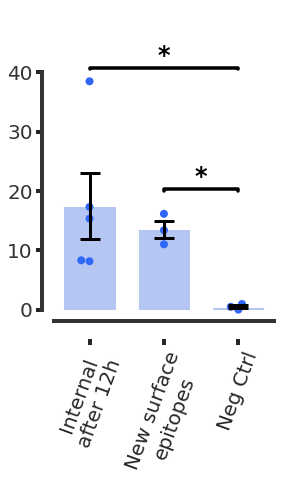

In [4]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker


df2plot=organelledf
order=df2plot["Protein"].unique()
var="corrected perc"
fig=plt.figure(figsize=(4,6))

g=sns.barplot(data=df2plot,y=var,x="Protein",
            color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .7)

g=sns.swarmplot(data=df2plot,y=var,x="Protein",color="#2F67F8",size=8)


plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)


plt.axhline(-2, color='#333333',alpha=1,linewidth=4)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Internal\nafter 12h',
      'New surface\nepitopes','Neg Ctrl'],
           rotation=70,size=20)

g.grid(False)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)

plt.yticks([0,10,20,30,40],fontsize=20,color='#333333')

plt.ylim([-5,50])

#diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

#fig.savefig(diri+'5b_confocal_colocs_integrins.svg', bbox_inches='tight', format='svg')